In [1]:
%run init_notebookspace.py
%run ..\settings.py
from settings import *

In [2]:
from src.utils import time_format, plot_df

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import datetime as dt
import os

%matplotlib inline
config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

## Load data

In [4]:
h_work = pd.read_csv(os.path.join(DATA_DIR, 'ita_hours_worked.csv'), parse_dates=['TIME'], infer_datetime_format=True)
int_r = pd.read_csv(os.path.join(DATA_DIR, 'ita_real_interest.csv'), parse_dates=['TIME'], infer_datetime_format=True)
a_hwage = pd.read_csv(os.path.join(DATA_DIR, 'ita_avg_hour_wage.csv'),parse_dates=['TIME'], infer_datetime_format=True)

other = pd.read_csv(os.path.join(DATA_DIR, 'ita_gdp_consumptions_investments.csv'),parse_dates=['TIME'], infer_datetime_format=True)

defl = pd.read_csv(os.path.join(DATA_DIR, 'ita_inflation_deflator.csv'), parse_dates=['DATE'], infer_datetime_format=True)

In [5]:
# prep deflator
defl["DATE"] = time_format(defl.DATE)
defl.set_index("DATE", inplace=True, drop=True)
defl.rename(columns={"ITAGDPDEFQISMEI": "defl"}, inplace=True)
defl = defl / defl.iloc[0, 0] # index to base 1996-Q1

In [6]:
int_r

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,ITA,STINT,TOT,PC_PA,Q,1978-10-01,11.483330,NaN
1,ITA,STINT,TOT,PC_PA,Q,1979-01-01,11.361700,NaN
2,ITA,STINT,TOT,PC_PA,Q,1979-04-01,11.353870,NaN
3,ITA,STINT,TOT,PC_PA,Q,1979-07-01,11.356130,NaN
4,ITA,STINT,TOT,PC_PA,Q,1979-10-01,13.004430,NaN
...,...,...,...,...,...,...,...,...
170,ITA,STINT,TOT,PC_PA,Q,2021-04-01,-0.540400,NaN
171,ITA,STINT,TOT,PC_PA,Q,2021-07-01,-0.545800,NaN
172,ITA,STINT,TOT,PC_PA,Q,2021-10-01,-0.566400,NaN
173,ITA,STINT,TOT,PC_PA,Q,2022-01-01,-0.528867,NaN


In [154]:
# work a_hwage
a_hwage = a_hwage[(a_hwage["Aggregate"] == "hourly index of wages according to collective labour agreements - base december 2015=100")
               &(a_hwage["Status of employee"] == "all employees excluding executives")]
a_hwage.rename(columns={"Value": 'a_hwage'}, inplace=True)
a_hwage["TIME"] = time_format(a_hwage.TIME)
a_hwage.set_index("TIME", inplace=True)
a_hwage = a_hwage[["a_hwage"]]

# index data in terms of base year
base_year = other.TIME.min().year

In [155]:
# merge deflator in other
other = pd.merge(other, defl, left_on="TIME", right_index=True)
other.sort_values("TIME", inplace=True)

In [156]:
# work gdp
out = []
col_names = ['invest', 'importx', 'gdp', 'consump', 'export']

for i, item in enumerate(other['Aggregate (millions of euro)'].drop_duplicates().values[:-1]):
    print(item, '\n')
    _ = other[
        (other['Aggregate (millions of euro)'] == item) 
        & (other['Adjustment'] == 'raw data') # only raw data, not detrend or seasonal
#         & (other['Valuation'] == 'chain linked - reference year 2015') # get real gdp
        & (other['Valuation'] == 'current prices') # get nominal GDP
        & (other["T_BIS"] == "2019M10")
    ].copy()
    
    # select cols
    _.set_index('TIME', inplace=True)
    _["Value"] = _["Value"] / _["defl"]
    
    _ = _[['Value']]
    _.rename(columns={'Value': col_names[i]}, inplace=True)

    out.append(pd.DataFrame(_))
    
invest, importx, gdp, consump, export = out

gross domestic product at market prices 

changes in inventories, acquisitions less disposals of valuables  

exports of goods (fob) and services  

imports of goods (fob) and services 

gross fixed capital formation 



In [157]:
# work interest rate
int_r = int_r[int_r['LOCATION'] == 'ITA']
int_r["TIME"] = time_format(int_r.TIME)
int_r.set_index('TIME', inplace=True)
int_r.rename(columns={'Value': 'int_r'}, inplace=True)
int_r = int_r[['int_r']]

int_r["int_r"] = int_r.int_r / 100 # transform to decimal

In [158]:
# work hours worked
h_work = h_work[(h_work['Edition'] == 'Sep-2022')
       &(h_work['Employment status'] == 'total')].rename(columns={'Value': 'h_work'})
h_work = h_work.groupby('TIME')[['h_work']].mean()

In [159]:
# merge data frames toghether based on QYear
dfs = [gdp, invest, importx, export, int_r, consump, a_hwage]
df = dfs[0].copy()
    
for i in range(1, len(dfs)):
    df = df.join(dfs[i].copy(), how='left')

In [160]:
# merge h_worked, based on year - constant for every quarter in one year
df['year'] = pd.Series(df.index).apply(lambda x: x.year).values
h_work['year'] = pd.Series(h_work.index).apply(lambda x: x.year).values
df = pd.merge(df.reset_index(), h_work, on='year').set_index('TIME')
df.drop('year', axis=1, inplace=True)

In [161]:
# asign time index
df = df.asfreq("QS")

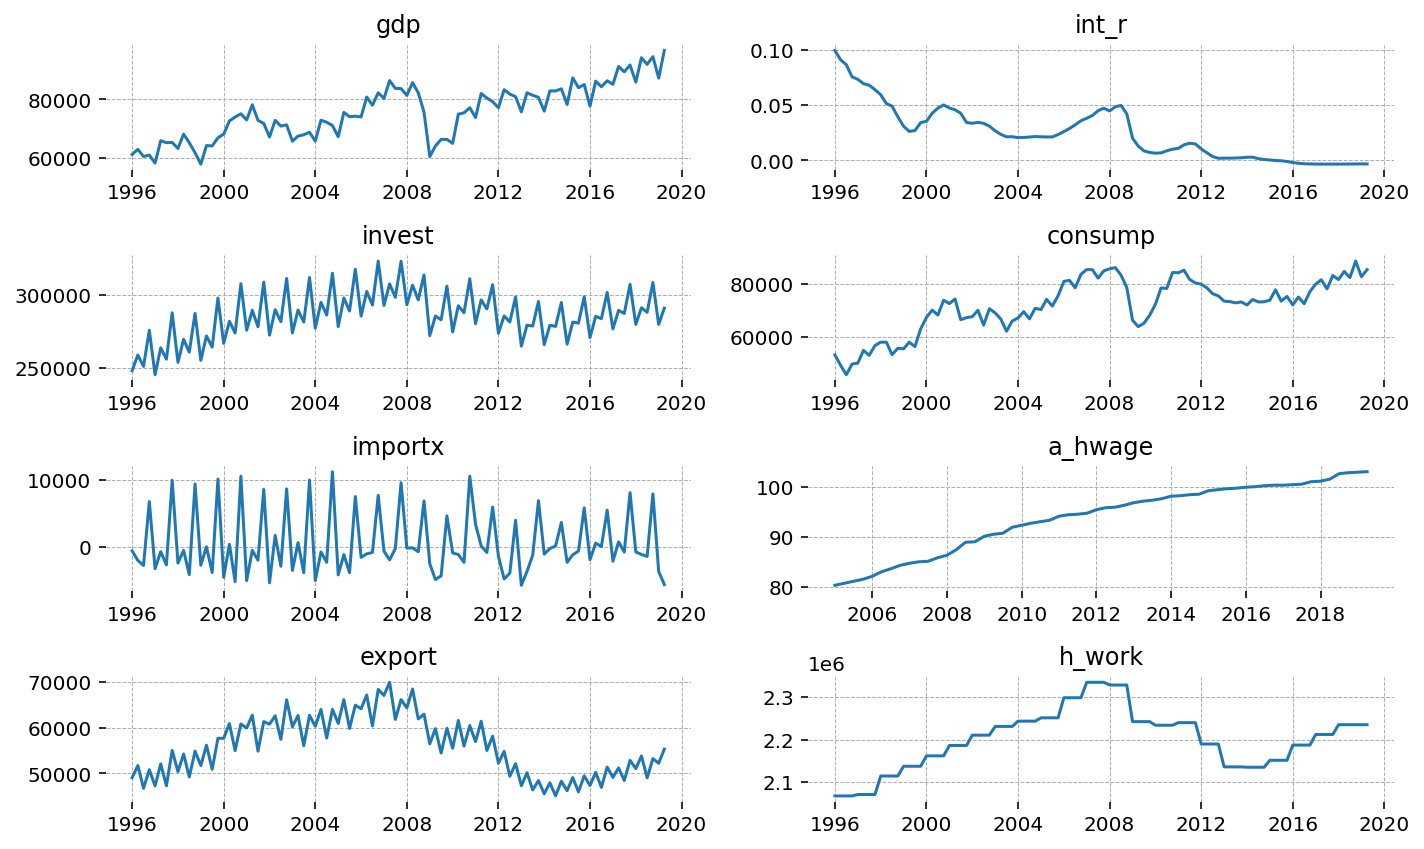

In [162]:
plot_df(df)

In [163]:
# save data
df.to_csv(os.path.join(DATA_DIR, 'all_rbc_data.csv'))